<h1>Карьерный Центр. Сопоставление геоназваний<span class="tocSkip"></span></h1>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**Бизнес-задача:** в базе данных Карьерного Центра есть названия географических объектов с разным написанием или ошибками, например:
- СПб
- Санкт-Петербург
- С.-Петербург
- Сант-Питербург

Необходимо их привести к единому виду согласно geonames:
- Saint Petersburg

GeoNames - это географическая база данных, которая охватывает все страны и содержит более одиннадцати миллионов географических названий, доступных для бесплатного скачивания. На основе этой базы строятся многие сервисы и плагины проверки и унификации адресов

**ML-задача:** Необходимо разработать ML-продукт, который:
- подбирает наиболее подходящие названия с geonames. Например Ереван -> Yerevan
- покажет хорошую точность на примере РФ и стран наиболее популярных для релокации - Беларусь, Армения, Казахстан, Кыргызстан, Турция, Сербия. Города с населением от 15000 человек (с возможностью масштабирования на сервере заказчика)

**Задачи опционально:**

- возможность настройки количества выдачи подходящих названий (например в параметрах метода);
- коррекция ошибок и опечаток. Например Моченгорск -> Monchegorsk;
- хранение в PostgreSQL данных geonames;
- хранение векторизованных промежуточных данных в PostgreSQL;
- предусмотреть методы для настройки подключения к БД;
- предусмотреть метод для инициализации класса (первичная векторизация geonames);
- предусмотреть методы для добавления векторов новых гео названий.

**Формат результата:**
- Возвращаемые поля geonameid, name, region, country, cosine similarity
- формат данных на выходе: список словарей, например [{dict_1}, {dict_2}, …. {dict_n}] где словарь - одна запись с указанными полями

<h2>Исходные данные<span class="tocSkip"></span></h2>

Ссылка на данные geonames:
http://download.geonames.org/export/dump/

Используемые таблицы с geonames:
- admin1CodesASCII;
- alternateNamesV2;
- cities500;
- countryInfo.

Дополнительно:
- Тестовый датасет.

## Разведывательный анализ данных

### Импорт данных

Импортируем необходимые для работы библиотеки. Считаем данные таблиц в датафреймы, сохраним в переменные и выведем на экран каждую таблицу.

In [1]:
# data analysis
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL

# NLP
import re
from Levenshtein import ratio
from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer
from transliterate import get_translit_function
import unicodedata
from lingua import (
    Language,
    LanguageDetectorBuilder
)

# misc
from ydata_profiling import ProfileReport
import pickle

# отображение всех столбцов таблицы
pd.set_option('display.max_columns', None)

In [2]:
# подключение к postgresql
DATABASE = {
    'drivername': 'postgresql',
    'username': 'postgres', 
    'password': '112358', 
    'host': 'localhost',
    'port': 5432,
    'database': 'postgres',
    'query': {}
}  

engine = create_engine(URL(**DATABASE))

In [3]:
'''
Функция выводит 5 первых и последних
записей датасета
'''
def show(data, info=False):
    print(data.shape)
    if info:
        print(data.info())
    return pd.concat([data.head(), data.tail()])

#### cities

In [4]:
query = 'SELECT * FROM cities500'
cities = pd.read_sql_query(query, con=engine)
show(cities, info=True)

(200670, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200670 entries, 0 to 200669
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              200670 non-null  int64  
 1   geonameid          200670 non-null  int64  
 2   name               200669 non-null  object 
 3   asciiname          200653 non-null  object 
 4   alternatenames     164866 non-null  object 
 5   latitude           200670 non-null  float64
 6   longitude          200670 non-null  float64
 7   feature class      200670 non-null  object 
 8   feature code       200670 non-null  object 
 9   country code       200625 non-null  object 
 10  cc2                87 non-null      object 
 11  admin1 code        200641 non-null  object 
 12  admin2 code        179721 non-null  object 
 13  admin3 code        91109 non-null   object 
 14  admin4 code        32647 non-null   object 
 15  population         200670 non-null  in

index  geonameid                 name            asciiname  \
0            0    3038999               Soldeu               Soldeu   
1            1    3039154            El Tarter            El Tarter   
2            2    3039163  Sant Julià de Lòria  Sant Julia de Loria   
3            3    3039604       Pas de la Casa       Pas de la Casa   
4            4    3039678               Ordino               Ordino   
200665  200665     895269           Beitbridge           Beitbridge   
200666  200666     895308             Beatrice             Beatrice   
200667  200667     895417               Banket               Banket   
200668  200668    1085510              Epworth              Epworth   
200669  200669    1106542          Chitungwiza          Chitungwiza   

                                           alternatenames  latitude  \
0                                                    None  42.57688   
1                                    Ehl Tarter,Эл Тартер  42.57952   
2       San Julia,San Julià,Sant Julia de Loria,Sant J...  42.46372   
3                           Pas de la Kasa,Пас де ла Каса  42.54277   
4       Ordino,ao er di nuo,orudino jiao qu,Ордино,オルデ...  42.55623   
200665  Bajtbridz,Bajtbridzh,Beitbridge,Beitbridzas,Be... -22.21667   
200666                                           Beatrice -18.25283   
200667                             Banket,Banket Junction -17.38333   
200668                                            Epworth -17.89000   
200669  Chitungviza,Chitungwiza,Chytungviza,Citungviza... -18.01274   

        longitude feature class feature code country code   cc2 admin1 code  \
0         1.66769             P          PPL           AD  None          02   
1         1.65362             P          PPL           AD  None          02   
2         1.49129             P         PPLA           AD  None          06   
3         1.73361             P          PPL           AD  None          03   
4         1.53319             P         PPLA           AD  None          05   
200665   30.00000             P          PPL           ZW  None          07   
200666   30.84730             P          PPL           ZW  None          04   
200667   30.40000             P          PPL           ZW  None          05   
200668   31.14750             P         PPLX           ZW  None          10   
200669   31.07555             P          PPL           ZW  None          10   

       admin2 code admin3 code admin4 code  population  elevation   dem  \
0             None        None        None         602        NaN  1832   
1             None        None        None        1052        NaN  1721   
2             None        None        None        8022        NaN   921   
3             None        None        None        2363     2050.0  2106   
4             None        None        None        3066        NaN  1296   
200665        None        None        None       58100        NaN   461   
200666        None        None        None        1647        NaN  1307   
200667        None        None        None        9641        NaN  1277   
200668        None        None        None      123250        NaN  1508   
200669        None        None        None      371244        NaN  1435   

              timezone modification date  
0       Europe/Andorra        2017-11-06  
1       Europe/Andorra        2012-11-03  
2       Europe/Andorra        2013-11-23  
3       Europe/Andorra        2008-06-09  
4       Europe/Andorra        2018-10-26  
200665   Africa/Harare        2022-10-07  
200666   Africa/Harare        2018-05-09  
200667   Africa/Harare        2013-03-12  
200668   Africa/Harare        2012-01-19  
200669   Africa/Harare        2022-10-05

Описание таблицы с сайта GeoNames:
- geonameid         : integer id of record in geonames database
- name              : name of geographical point (utf8) varchar(200)
- asciiname         : name of geographical point in plain ascii characters, varchar(200)
- alternatenames    : alternatenames, comma separated, ascii names automatically transliterated, convenience attribute from alternatename table, varchar(10000)
- latitude          : latitude in decimal degrees (wgs84)
- longitude         : longitude in decimal degrees (wgs84)
- feature class     : see http://www.geonames.org/export/codes.html, char(1)
- feature code      : see http://www.geonames.org/export/codes.html, varchar(10)
- country code      : ISO-3166 2-letter country code, 2 characters
- cc2               : alternate country codes, comma separated, ISO-3166 2-letter country code, 200 characters
- admin1 code       : fipscode (subject to change to iso code), see exceptions below, see file admin1Codes.txt for display - names of this code; varchar(20)
- admin2 code       : code for the second administrative division, a county in the US, see file admin2Codes.txt; varchar(80) 
- admin3 code       : code for third level administrative division, varchar(20)
- admin4 code       : code for fourth level administrative division, varchar(20)
- population        : bigint (8 byte int) 
- elevation         : in meters, integer
- dem               : digital elevation model, srtm3 or gtopo30, average elevation of 3''x3'' (ca 90mx90m) or 30''x30'' (ca 900mx900m) area in meters, integer. srtm processed by cgiar/ciat.
- timezone          : the iana timezone id (see file timeZone.txt) varchar(40)
- modification date : date of last modification in yyyy-MM-dd format

В таблице 200670 записей, наиболее интересные столбцы – `geonameid`, `asciiname`, `alternatenames`.

In [5]:
# создание репорта с описанием
full_profile = ProfileReport(cities, title="Full Report", explorative=True)
full_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

`geonameid` не имеет повторяющихся значений, дубликатов не найдено, в полях `alternatenames` и `asciiname` есть пропуски. Рассмотрим эти пропуски поближе.

In [6]:
cities.loc[cities['asciiname'].isna()]

df_index  geonameid         name asciiname  \
106689    106689    3172215         None      None   
165397    165379     583509       Ak”yar      None   
169191    169191    8986867     Gradiška      None   
169197    169197    8986873      Zaboršt      None   
169201    169201    8986877     Parižlje      None   
169209    169209    8986885  Nova Štifta      None   
169210    169210    8986886       Puštal      None   
169212    169212    8986888      Hajdoše      None   
169216    169216    8986892        Žižki      None   
169217    169217    8986893         Leše      None   
169219    169219    8986895       Nožice      None   
169224    169224    8986900       Šalara      None   
169226    169226    8986902    Bošamarin      None   
169227    169227    8986903        Pušča      None   
169230    169230    8986906        Žlebe      None   
169231    169231    8986907         Vaše      None   
169235    169235    8986911     Zamušani      None   

                                           alternatenames  latitude  \
106689                                      None,none,ノーネ  44.93645   
165397  Akjar,Akujar,Ak”yar,Khaibulina,Khaybulino,Khay...  51.85905   
169191                                           GradiKa  46.61728   
169197                                            ZaborT  46.13539   
169201                                           PariLje  46.27973   
169209                                        Nova Tifta  46.27469   
169210                                             PuTal  46.15064   
169212                                            HajdoE  46.43289   
169216                      Zizki,Zsizsekszer,IKi,Žižki  46.56721   
169217                                     Lese,LeE,Leše  46.52846   
169219                                             NoIce  46.18466   
169224                                             Alara  45.51849   
169226                                          BoAmarin  45.52028   
169227                                              PuČa  46.65573   
169230                                              Lebe  46.11541   
169231                                               VaE  46.13435   
169235                                           ZamuAni  46.42204   

        longitude feature class feature code country code   cc2 admin1 code  \
106689    7.54015             P        PPLA3           IT  None          12   
165397   58.22136             P          PPL           RU  None          08   
169191   15.64797             P          PPL           SI  None          55   
169197   14.61294             P          PPL           SI  None          G7   
169201   15.05669             P          PPL           SI  None          F7   
169209   14.74917             P          PPL           SI  None          30   
169210   14.31186             P          PPL           SI  None          B9   
169212   15.82614             P          PPL           SI  None          G9   
169216   16.31499             P          PPL           SI  None          15   
169217   14.89385             P          PPL           SI  None          K6   
169219   14.59525             P          PPL           SI  None          G7   
169224   13.71757             P          PPL           SI  None          50   
169226   13.73584             P          PPL           SI  None          50   
169227   16.13903             P          PPL           SI  None          80   
169230   14.39582             P          PPL           SI  None          71   
169231   14.39542             P          PPL           SI  None          71   
169235   16.02938             P          PPL           SI  None          28   

       admin2 code admin3 code admin4 code  population  elevation  dem  \
106689          TO      001168        None        7507      246.0  248   
165397        None        None        None        5549        NaN  330   
169191        None        None        None         929        NaN  264   
169197        None        None       

Итальянский город Ноне превратился в тип None, в остальных случаях можно заполнить пропуски значениями из столбца `name`.

In [7]:
# индексы пропущенных значений
idx = cities.loc[cities['asciiname'].isna()].index

# город Ноне
cities.loc[cities['geonameid'] == 3172215, 'asciiname'] = str(None)

In [8]:
# функция для приведения названий к ascii
def to_ascii(string):
    string = str(
        unicodedata.normalize('NFD', string)
        .encode('ascii', 'ignore'))
    return string[2:-1]

In [9]:
# заполнение пропусков и проверка
cities.loc[
    cities['asciiname'].isna(), 'asciiname'] = cities.loc[
    cities['asciiname'].isna(), 'name']\
      .apply(to_ascii)

print('Количество пропусков в asciiname:',
      cities['asciiname'].isna().sum())
cities.iloc[idx]

Количество пропусков в asciiname: 0


df_index  geonameid         name    asciiname  \
106689    106689    3172215         None         None   
165397    165379     583509       Ak”yar        Akyar   
169191    169191    8986867     Gradiška     Gradiska   
169197    169197    8986873      Zaboršt      Zaborst   
169201    169201    8986877     Parižlje     Parizlje   
169209    169209    8986885  Nova Štifta  Nova Stifta   
169210    169210    8986886       Puštal       Pustal   
169212    169212    8986888      Hajdoše      Hajdose   
169216    169216    8986892        Žižki        Zizki   
169217    169217    8986893         Leše         Lese   
169219    169219    8986895       Nožice       Nozice   
169224    169224    8986900       Šalara       Salara   
169226    169226    8986902    Bošamarin    Bosamarin   
169227    169227    8986903        Pušča        Pusca   
169230    169230    8986906        Žlebe        Zlebe   
169231    169231    8986907         Vaše         Vase   
169235    169235    8986911     Zamušani     Zamusani   

                                           alternatenames  latitude  \
106689                                      None,none,ノーネ  44.93645   
165397  Akjar,Akujar,Ak”yar,Khaibulina,Khaybulino,Khay...  51.85905   
169191                                           GradiKa  46.61728   
169197                                            ZaborT  46.13539   
169201                                           PariLje  46.27973   
169209                                        Nova Tifta  46.27469   
169210                                             PuTal  46.15064   
169212                                            HajdoE  46.43289   
169216                      Zizki,Zsizsekszer,IKi,Žižki  46.56721   
169217                                     Lese,LeE,Leše  46.52846   
169219                                             NoIce  46.18466   
169224                                             Alara  45.51849   
169226                                          BoAmarin  45.52028   
169227                                              PuČa  46.65573   
169230                                              Lebe  46.11541   
169231                                               VaE  46.13435   
169235                                           ZamuAni  46.42204   

        longitude feature class feature code country code   cc2 admin1 code  \
106689    7.54015             P        PPLA3           IT  None          12   
165397   58.22136             P          PPL           RU  None          08   
169191   15.64797             P          PPL           SI  None          55   
169197   14.61294             P          PPL           SI  None          G7   
169201   15.05669             P          PPL           SI  None          F7   
169209   14.74917             P          PPL           SI  None          30   
169210   14.31186             P          PPL           SI  None          B9   
169212   15.82614             P          PPL           SI  None          G9   
169216   16.31499             P          PPL           SI  None          15   
169217   14.89385             P          PPL           SI  None          K6   
169219   14.59525             P          PPL           SI  None          G7   
169224   13.71757             P          PPL           SI  None          50   
169226   13.73584             P          PPL           SI  None          50   
169227   16.13903             P          PPL           SI  None          80   
169230   14.39582             P          PPL           SI  None          71   
169231   14.39542             P          PPL           SI  None          71   
169235   16.02938             P          PPL           SI  None          28   

       admin2 code admin3 code admin4 code  population  elevation  dem  \
106689          TO      001168        None        7507      246.0  248   
165397        None        None        None        5549        NaN  330   
169191        None        None        None         929   

Признаки `country code` и `admin1 code` понадобятся в дальнейшем для объединения таблиц, однако в них тоже есть пропуски (45 и 29 соответственно). Так как их мало, можно удалить эти объекты.

In [10]:
cities.dropna(subset=['country code', 'admin1 code'], inplace=True)
print('Количество пропусков:',
      cities[['country code', 'admin1 code']].isna().sum(),
      sep='\n')

Количество пропусков:
country code    0
admin1 code     0
dtype: int64


#### alternateNamesV2

In [11]:
# таблица слишком большая для пандаса, поэтому загружаем только часть
query = 'SELECT * FROM "alternateNamesV2" LIMIT 10000'
alt_names = pd.read_sql_query(query, con=engine)
show(alt_names, info=True)

(10000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   alternateNameId  10000 non-null  object
 1   geonameid        10000 non-null  object
 2   isolanguage      10000 non-null  object
 3   alternate name   10000 non-null  object
 4   isPreferredName  10000 non-null  object
 5   isShortName      10000 non-null  object
 6   isColloquial     10000 non-null  object
 7   isHistoric       10000 non-null  object
 8   from             10000 non-null  object
 9   to               10000 non-null  object
dtypes: object(10)
memory usage: 781.4+ KB
None


alternateNameId geonameid isolanguage          alternate name  \
0             563070   1127185                 Gaṟḏana-i-Saṟe Hōs̄   
1            3609604   1127185              Gardaneh-ye Sar-e Hūsh   
2            5426876   1127185              Gardanah-ye Sar-e Hōsh   
3            5426877   1127185                        گردنۀ سر هوش   
4           15569658   1127185        wkdt               Q21748486   
9995         8238475   1129263                Shēlah-ye Qāsim ‘Alī   
9996          566173   1129264                          Qāsim Ābāḏ   
9997         3090561   1129264                           Qāsimābād   
9998         3090562   1129264                           قاسم آباد   
9999         3090563   1129264                           Qāsemābād   

     isPreferredName isShortName isColloquial isHistoric from to  
0                                                                 
1                                                                 
2                                                                 
3                                                                 
4                                                                 
9995                                                              
9996                                                              
9997                                                              
9998                                                              
9999

Описание таблицы с сайта GeoNames:
- alternateNameId   : the id of this alternate name, int
- geonameid         : geonameId referring to id in table 'geoname', int
- isolanguage       : iso 639 language code 2- or 3-characters, optionally followed by a hyphen and a countrycode for country specific variants (ex:zh-CN) or by a variant name (ex: zh-Hant); 4-characters 'post' for postal codes and 'iata','icao' and faac for airport codes, fr_1793 for French Revolution names,  abbr for abbreviation, link to a website (mostly to wikipedia), wkdt for the wikidataid, varchar(7)
- alternate name    : alternate name or name variant, varchar(400)
- isPreferredName   : '1', if this alternate name is an official/preferred name
- isShortName       : '1', if this is a short name like 'California' for 'State of California'
- isColloquial      : '1', if this alternate name is a colloquial or slang term. Example: 'Big Apple' for 'New York'.
- isHistoric        : '1', if this alternate name is historic and was used in the past. Example 'Bombay' for 'Mumbai'.
- from		  : from period when the name was used
- to		  : to period when the name was used

Можно заметить, что таблица alternateNamesV2 вроде как повторяет столбец `alternatenames` таблицы cities в части названий населенных пунктов. Проверим, так ли это на примере города с большим количеством альтернативных названий, например, Москвы.

In [12]:
# создаем список с альтернативными именами Москвы из таблицы cities
temp_cities = list(cities.query('geonameid == 524901')['alternatenames'])
temp_cities = temp_cities[0].split(',')
print('Количество имен:', len(temp_cities))
temp_cities

Количество имен: 93


['MOW',
 'Maeskuy',
 'Maskav',
 'Maskava',
 'Maskva',
 'Mat-xco-va',
 'Matxcova',
 'Matxcơva',
 'Mosca',
 'Moscfa',
 'Moscha',
 'Mosco',
 'Moscou',
 'Moscova',
 'Moscovo',
 'Moscow',
 'Moscoƿ',
 'Moscu',
 'Moscua',
 'Moscòu',
 'Moscó',
 'Moscù',
 'Moscú',
 'Moskva',
 'Moska',
 'Moskau',
 'Mosko',
 'Moskokh',
 'Moskou',
 'Moskov',
 'Moskova',
 'Moskovu',
 'Moskow',
 'Moskowa',
 'Mosku',
 'Moskuas',
 'Moskva',
 'Moskve',
 'Moskvo',
 'Moskvy',
 'Moskwa',
 'Moszkva',
 'Muskav',
 'Musko',
 'Mát-xcơ-va',
 'Mòskwa',
 'Məskeu',
 'Məskəү',
 'masko',
 'maskw',
 'mo si ke',
 'moseukeuba',
 'mosko',
 'mosukuwa',
 'mskw',
 'mwskva',
 'mwskw',
 'mwsqbh',
 'mx s ko',
 'Μόσχα',
 'Мæскуы',
 'Маскав',
 'Масква',
 'Москва',
 'Москве',
 'Москвы',
 'Москова',
 'Москох',
 'Москъва',
 'Мускав',
 'Муско',
 'Мәскеу',
 'Мәскәү',
 'Մոսկվա',
 'מאָסקװע',
 'מאסקווע',
 'מוסקבה',
 'ماسکو',
 'مسکو',
 'موسكو',
 'موسكۋا',
 'ܡܘܣܩܒܐ',
 'मास्को',
 'मॉस्को',
 'মস্কো',
 'மாஸ்கோ',
 'มอสโก',
 'མོ་སི་ཁོ།',
 'მოსკოვი',
 'ሞስኮ',
 

In [13]:
# создаем список с альтернативными именами Москвы из таблицы alternateNamesV2
query = 'SELECT * FROM "alternateNamesV2" WHERE "geonameid" = TEXT(524901)'
temp_alt = list(pd.read_sql_query(query, con=engine)['alternate name'])
print('Количество имен:', len(temp_alt))
temp_alt

Количество имен: 118


['Moskva',
 'Moskau',
 'Moscou',
 'Moscú',
 'Moskvo',
 'Moscow',
 'Moskou',
 'Moskau',
 'Moscú',
 'موسكو',
 'Moscú',
 'Масква',
 'Москва',
 'Moscou',
 'Moskva',
 'Mòskwa',
 'Мускав',
 'Moscfa',
 'Moskva',
 'Μόσχα',
 'Moskva',
 'مسکو',
 'Moskova',
 'Moscó',
 'Moscova',
 'מוסקבה',
 'मास्को',
 'Moskva',
 'Moszkva',
 'Moskwa',
 'Moskva',
 'Moskva',
 'Mosca',
 'モスクワ',
 'Moskuas',
 'მოსკოვი',
 '모스크바',
 'Moscua',
 'Moskau',
 'Moskou',
 'Maskva',
 'Maskava',
 'Москва',
 'Москова',
 'Moskau',
 'Moskou',
 'Moskva',
 'Moscou',
 'Мæскуы',
 'Moskwa',
 'Moscovo',
 'Moscova',
 'Mosca',
 'Moskva',
 'Moskva',
 'Москва',
 'Moskva',
 'มอสโก',
 'Moskova',
 'Мәскәү',
 'Москва',
 'Mát-xcơ-va',
 'Moscou',
 'מאָסקװע',
 '莫斯科',
 'Moscoƿ',
 'Mosku',
 'Moscova',
 'Mosko',
 'Moskva',
 'مسکو',
 'மாஸ்கோ',
 'Муско',
 'موسكۋا',
 'Moskva',
 'Moskva',
 'ሞስኮ',
 'ܡܘܣܩܒܐ',
 'মস্কো',
 'མོ་སི་ཁོ།',
 'Moskva',
 'Москох',
 'Moscù',
 'Москъва',
 'Moskowa',
 'Moscou',
 'Moskou',
 'Moskwa',
 'Մոսկվա',
 'Moskow',
 'मॉस्को',
 'Mosc

Во втором списке названий больше, создадим список, в котором будут названия, которые не совпали.

In [14]:
temp_result = [i for i in temp_alt if i not in temp_cities]
temp_result

['https://en.wikipedia.org/wiki/Moscow',
 'https://uk.wikipedia.org/wiki/%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0',
 'http://id.loc.gov/authorities/names/n79076156',
 'RUMOW',
 'Q649']

Остались только ссылки и численные обозначения, остальные названия совпали. Таким образом, столбец `alternatenames` таблицы cities можно использовать без подгрузки названий из таблицы AlternateNamesV2.

#### admin1CodesASCII

In [15]:
query = 'SELECT * FROM "admin1CodesASCII"'
admin = pd.read_sql_query(query, con=engine)
show(admin, info=True)

(3881, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3881 entries, 0 to 3880
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       3881 non-null   int64 
 1   code        3881 non-null   object
 2   name        3881 non-null   object
 3   name ascii  3881 non-null   object
 4   geonameid   3881 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 151.7+ KB
None


index   code                 name           name ascii  geonameid
0         0  AD.06  Sant Julià de Loria  Sant Julia de Loria    3039162
1         1  AD.05               Ordino               Ordino    3039676
2         2  AD.04           La Massana           La Massana    3040131
3         3  AD.03               Encamp               Encamp    3040684
4         4  AD.02              Canillo              Canillo    3041203
3876   3876  ZW.04     Mashonaland East     Mashonaland East     886842
3877   3877  ZW.03  Mashonaland Central  Mashonaland Central     886843
3878   3878  ZW.01           Manicaland           Manicaland     887358
3879   3879  ZW.09             Bulawayo             Bulawayo    1105843
3880   3880  ZW.10               Harare               Harare    1105844

Описание таблицы с сайта GeoNames:
- geonameid         : integer id of record in geonames database
- name              : name of geographical point (utf8)
- name ascii         : name of geographical point in plain ascii characters,
- code   : fipscode (subject to change to iso code)

Из данной таблицы будем получать название региона по коду страны с номером.

#### countryInfo

In [16]:
query = 'SELECT * FROM "countryInfo"'
country_info = pd.read_sql_query(query, con=engine)
show(country_info, info=True)

(252, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               252 non-null    int64  
 1   ISO                 251 non-null    object 
 2   ISO3                252 non-null    object 
 3   ISO-Numeric         252 non-null    int64  
 4   fips                249 non-null    object 
 5   Country             252 non-null    object 
 6   Capital             246 non-null    object 
 7   Area(in sq km)      252 non-null    float64
 8   Population          252 non-null    int64  
 9   Continent           210 non-null    object 
 10  tld                 251 non-null    object 
 11  CurrencyCode        251 non-null    object 
 12  CurrencyName        251 non-null    object 
 13  Phone               247 non-null    object 
 14  Postal Code Format  162 non-null    object 
 15  Postal Code Regex   162 non-null    object 
 16

index ISO ISO3  ISO-Numeric fips                Country  \
0        0  AD  AND           20   AN                Andorra   
1        1  AE  ARE          784   AE   United Arab Emirates   
2        2  AF  AFG            4   AF            Afghanistan   
3        3  AG  ATG           28   AC    Antigua and Barbuda   
4        4  AI  AIA          660   AV               Anguilla   
247    247  ZA  ZAF          710   SF           South Africa   
248    248  ZM  ZMB          894   ZA                 Zambia   
249    249  ZW  ZWE          716   ZI               Zimbabwe   
250    250  CS  SCG          891   YI  Serbia and Montenegro   
251    251  AN  ANT          530   NT   Netherlands Antilles   

              Capital  Area(in sq km)  Population Continent  tld CurrencyCode  \
0    Andorra la Vella           468.0       77006        EU  .ad          EUR   
1           Abu Dhabi         82880.0     9630959        AS  .ae          AED   
2               Kabul        647500.0    37172386        AS  .af          AFN   
3          St. John's           443.0       96286      None  .ag          XCD   
4          The Valley           102.0       13254      None  .ai          XCD   
247          Pretoria       1219912.0    57779622        AF  .za          ZAR   
248            Lusaka        752614.0    17351822        AF  .zm          ZMW   
249            Harare        390580.0    14439018        AF  .zw          ZWL   
250          Belgrade        102350.0    10829175        EU  .cs          RSD   
251        Willemstad           960.0      300000      None  .an          ANG   

    CurrencyName   Phone Postal Code Format Postal Code Regex  \
0           Euro     376              AD###  ^(?:AD)*(\d{3})$   
1         Dirham     971               None              None   
2        Afghani      93               None              None   
3         Dollar  +1-268               None              None   
4         Dollar  +1-264               None              None   
247         Rand      27               ####         ^(\d{4})$   
248       Kwacha     260              #####         ^(\d{5})$   
249       Dollar     263               None              None   
250        Dinar     381              #####         ^(\d{5})$   
251      Guilder     599               None              None   

                                Languages  geonameid            neighbours  \
0                                      ca    3041565                 ES,FR   
1                       ar-AE,fa,en,hi,ur     290557                 SA,OM   
2                       fa-AF,ps,uz-AF,tk    1149361     TM,CN,IR,TJ,PK,UZ   
3                                   en-AG    3576396                  None   
4                                   en-AI    3573511                  None   
247  zu,xh,af,nso,en-ZA,tn,st,ts,ss,ve,nr     953987     ZW,SZ,MZ,BW,NA,LS   
248          en-ZM,bem,loz,lun,lue,ny,toi     895949  ZW,TZ,MZ,CD,NA,MW,AO   
249                        en-ZW,sn,nr,nd     878675           ZA,MZ,BW,ZM   
250                           cu,hu,sq,sr    8505033  AL,HU,MK,RO,HR,BA,BG   
251                           nl-AN,en,es    8505032                    GP   

    EquivalentFipsCode  
0                 None  
1                 None  
2                 None  
3                 None  
4                 None  
247               None  
248               None  
249               None  
250               None  
251               None

В данной таблице нас интересует столбцы `ISO` и `Country`, отсюда мы будем получать название страны.

#### geo_test

In [17]:
test = pd.read_csv('geo_test.csv', delimiter=';')
show(test)

(345, 4)


query           name            region     country
0        Смоленск       Smolensk   Smolensk Oblast      Russia
1        Кемерово       Kemerovo           Kuzbass      Russia
2          Бишкек        Bishkek           Bishkek  Kyrgyzstan
3          Москва         Moscow            Moscow      Russia
4          Алматы         Almaty            Almaty  Kazakhstan
340  Отеген-Батыр  Otegen Batyra            Almaty  Kazakhstan
341        Тамань         Taman’    Krasnodar Krai      Russia
342        Ачинск        Achinsk  Krasnoyarsk Krai      Russia
343      Трудовое      Trudovoye          Primorye      Russia
344    Московский     Moskovskiy            Moscow      Russia

Тестовый датасет, с форматом: запрос – название населенного пункта - регион - страна.

**Промежуточный вывод:** все таблицы успешно загружены, заполнено часть пропусков, часть объектов с пропусками в данных удалена. Таблицы готовы к объединению.

### Объединение таблиц

Объединим данные, чтобы в одной таблице была вся необходимая информация.

In [18]:
# создание ключа, по которому будут присоединяться регионы
cities['code'] = cities['country code'] + '.' + cities['admin1 code']
show(cities)

(200596, 21)


df_index  geonameid                 name            asciiname  \
0              0    3038999               Soldeu               Soldeu   
1              1    3039154            El Tarter            El Tarter   
2              2    3039163  Sant Julià de Lòria  Sant Julia de Loria   
3              3    3039604       Pas de la Casa       Pas de la Casa   
4              4    3039678               Ordino               Ordino   
200665    200665     895269           Beitbridge           Beitbridge   
200666    200666     895308             Beatrice             Beatrice   
200667    200667     895417               Banket               Banket   
200668    200668    1085510              Epworth              Epworth   
200669    200669    1106542          Chitungwiza          Chitungwiza   

                                           alternatenames  latitude  \
0                                                    None  42.57688   
1                                    Ehl Tarter,Эл Тартер  42.57952   
2       San Julia,San Julià,Sant Julia de Loria,Sant J...  42.46372   
3                           Pas de la Kasa,Пас де ла Каса  42.54277   
4       Ordino,ao er di nuo,orudino jiao qu,Ордино,オルデ...  42.55623   
200665  Bajtbridz,Bajtbridzh,Beitbridge,Beitbridzas,Be... -22.21667   
200666                                           Beatrice -18.25283   
200667                             Banket,Banket Junction -17.38333   
200668                                            Epworth -17.89000   
200669  Chitungviza,Chitungwiza,Chytungviza,Citungviza... -18.01274   

        longitude feature class feature code country code   cc2 admin1 code  \
0         1.66769             P          PPL           AD  None          02   
1         1.65362             P          PPL           AD  None          02   
2         1.49129             P         PPLA           AD  None          06   
3         1.73361             P          PPL           AD  None          03   
4         1.53319             P         PPLA           AD  None          05   
200665   30.00000             P          PPL           ZW  None          07   
200666   30.84730             P          PPL           ZW  None          04   
200667   30.40000             P          PPL           ZW  None          05   
200668   31.14750             P         PPLX           ZW  None          10   
200669   31.07555             P          PPL           ZW  None          10   

       admin2 code admin3 code admin4 code  population  elevation   dem  \
0             None        None        None         602        NaN  1832   
1             None        None        None        1052        NaN  1721   
2             None        None        None        8022        NaN   921   
3             None        None        None        2363     2050.0  2106   
4             None        None        None        3066        NaN  1296   
200665        None        None        None       58100        NaN   461   
200666        None        None        None        1647        NaN  1307   
200667        None        None        None        9641        NaN  1277   
200668        None        None        None      123250        NaN  1508   
200669        None        None        None      371244        NaN  1435   

              timezone modification date   code  
0       Europe/Andorra        2017-11-06  AD.02  
1       Europe/Andorra        2012-11-03  AD.02  
2       Europe/Andorra        2013-11-23  AD.06  
3       Europe/Andorra        2008-06-09  AD.03  
4       Europe/Andorra        2018-10-26  AD.05  
200665   Africa/Harare        2022-10-07  ZW.07  
200666   Africa/Harare        2018-05-09  ZW.04  
200667   Africa/Harare        2013-03-12  ZW.05  
200668   Africa/Harare        2012-01-19  ZW.10  
200669   Africa/Harare        2022-10-05  ZW.10

In [19]:
# присоединение регионов
cities = cities.merge(
    right=admin,
    left_on=['code'],
    right_on=['code'],
    how = 'inner',
)
show(cities)

(200492, 25)


df_index  geonameid_x               name_x            asciiname  \
0              0      3038999               Soldeu               Soldeu   
1              1      3039154            El Tarter            El Tarter   
2              9      3041204              Canillo              Canillo   
3              2      3039163  Sant Julià de Lòria  Sant Julia de Loria   
4              3      3039604       Pas de la Casa       Pas de la Casa   
200487    200665       895269           Beitbridge           Beitbridge   
200488    200643       890299               Harare               Harare   
200489    200668      1085510              Epworth              Epworth   
200490    200669      1106542          Chitungwiza          Chitungwiza   
200491    200662       894701             Bulawayo             Bulawayo   

                                           alternatenames  latitude  \
0                                                    None  42.57688   
1                                    Ehl Tarter,Эл Тартер  42.57952   
2       Canillo,Kanil'o,ka ni e,kaniryo jiao qu,Каниль...  42.56760   
3       San Julia,San Julià,Sant Julia de Loria,Sant J...  42.46372   
4                           Pas de la Kasa,Пас де ла Каса  42.54277   
200487  Bajtbridz,Bajtbridzh,Beitbridge,Beitbridzas,Be... -22.21667   
200488  Arare,Charare,HRE,Harare,Hararensis Urbs,Harar... -17.82772   
200489                                            Epworth -17.89000   
200490  Chitungviza,Chitungwiza,Chytungviza,Citungviza... -18.01274   
200491  BUQ,Bulavajas,Bulavajo,Bulavejo,Bulawayo,bu la... -20.15000   

        longitude feature class feature code country code   cc2 admin1 code  \
0         1.66769             P          PPL           AD  None          02   
1         1.65362             P          PPL           AD  None          02   
2         1.59756             P         PPLA           AD  None          02   
3         1.49129             P         PPLA           AD  None          06   
4         1.73361             P          PPL           AD  None          03   
200487   30.00000             P          PPL           ZW  None          07   
200488   31.05337             P         PPLC           ZW  None          10   
200489   31.14750             P         PPLX           ZW  None          10   
200490   31.07555             P          PPL           ZW  None          10   
200491   28.58333             P         PPLA           ZW  None          09   

       admin2 code admin3 code admin4 code  population  elevation   dem  \
0             None        None        None         602        NaN  1832   
1             None        None        None        1052        NaN  1721   
2             None        None        None        3292        NaN  1561   
3             None        None        None        8022        NaN   921   
4             None        None        None        2363     2050.0  2106   
200487        None        None        None       58100        NaN   461   
200488        None        None        None     1542813        NaN  1494   
200489        None        None        None      123250        NaN  1508   
200490        None        None        None      371244        NaN  1435   
200491        None        None        None     1200337        NaN  1348   

              timezone modification date   code  index               name_y  \
0       Europe/Andorra        2017-11-06  AD.02      4              Canillo   
1       Europe/Andorra        2012-11-03  AD.02      4              Canillo   
2       Europe/Andorra        2018-10-26  AD.02      4              Canillo   
3       Europe/Andorra        2013-11-23  AD.06      0  Sant Julià de Loria   
4       Europe/Andorra        2008-06-09  AD.03      3               Encamp   
200487   Africa/Harare        2022-10-07  ZW.07   3872   Matabeleland South   
200488   Africa/Harare        2019-09-05  ZW.10   3880               Harare   
200489   Africa/Harare        2012-01-19  ZW.10   3880               Har

In [20]:
# присоединение стран
cities = cities.merge(
    right=country_info,
    left_on=['country code'],
    right_on=['ISO']
)
show(cities)

(200492, 45)


df_index  geonameid_x               name_x            asciiname  \
0              0      3038999               Soldeu               Soldeu   
1              1      3039154            El Tarter            El Tarter   
2              9      3041204              Canillo              Canillo   
3              2      3039163  Sant Julià de Lòria  Sant Julia de Loria   
4              3      3039604       Pas de la Casa       Pas de la Casa   
200487    200665       895269           Beitbridge           Beitbridge   
200488    200643       890299               Harare               Harare   
200489    200668      1085510              Epworth              Epworth   
200490    200669      1106542          Chitungwiza          Chitungwiza   
200491    200662       894701             Bulawayo             Bulawayo   

                                           alternatenames  latitude  \
0                                                    None  42.57688   
1                                    Ehl Tarter,Эл Тартер  42.57952   
2       Canillo,Kanil'o,ka ni e,kaniryo jiao qu,Каниль...  42.56760   
3       San Julia,San Julià,Sant Julia de Loria,Sant J...  42.46372   
4                           Pas de la Kasa,Пас де ла Каса  42.54277   
200487  Bajtbridz,Bajtbridzh,Beitbridge,Beitbridzas,Be... -22.21667   
200488  Arare,Charare,HRE,Harare,Hararensis Urbs,Harar... -17.82772   
200489                                            Epworth -17.89000   
200490  Chitungviza,Chitungwiza,Chytungviza,Citungviza... -18.01274   
200491  BUQ,Bulavajas,Bulavajo,Bulavejo,Bulawayo,bu la... -20.15000   

        longitude feature class feature code country code   cc2 admin1 code  \
0         1.66769             P          PPL           AD  None          02   
1         1.65362             P          PPL           AD  None          02   
2         1.59756             P         PPLA           AD  None          02   
3         1.49129             P         PPLA           AD  None          06   
4         1.73361             P          PPL           AD  None          03   
200487   30.00000             P          PPL           ZW  None          07   
200488   31.05337             P         PPLC           ZW  None          10   
200489   31.14750             P         PPLX           ZW  None          10   
200490   31.07555             P          PPL           ZW  None          10   
200491   28.58333             P         PPLA           ZW  None          09   

       admin2 code admin3 code admin4 code  population  elevation   dem  \
0             None        None        None         602        NaN  1832   
1             None        None        None        1052        NaN  1721   
2             None        None        None        3292        NaN  1561   
3             None        None        None        8022        NaN   921   
4             None        None        None        2363     2050.0  2106   
200487        None        None        None       58100        NaN   461   
200488        None        None        None     1542813        NaN  1494   
200489        None        None        None      123250        NaN  1508   
200490        None        None        None      371244        NaN  1435   
200491        None        None        None     1200337        NaN  1348   

              timezone modification date   code  index_x               name_y  \
0       Europe/Andorra        2017-11-06  AD.02        4              Canillo   
1       Europe/Andorra        2012-11-03  AD.02        4              Canillo   
2       Europe/Andorra        2018-10-26  AD.02        4              Canillo   
3       Europe/Andorra        2013-11-23  AD.06        0  Sant Julià de Loria   
4       Europe/Andorra        2008-06-09  AD.03        3               Encamp   
200487   Africa/Harare        2022-10-07  ZW.07     3872   Matabeleland South   
200488   Africa/Harare        2019-09-05  ZW.10     3880               Harare   
200489   Africa/Harare        2012-01-19  ZW.10     3880

In [21]:
cities.rename(columns={'Country':'country',
                       'name ascii':'region'},
              inplace=True)

`geonameid_x` отвечает за айди населенных пунктов, `geonameid_y` – за айди регионов.

Так как в данной задаче мы ограничиваемся странами СНГ, а также Грузией, Сербией и Турцией, то оставим только эти страны.

In [22]:
countries = ['AZ', 'AM', 'BY',
             'KG', 'KZ', 'MD',
             'RU', 'TJ', 'UZ',
             'GE', 'RS', 'TR']

cities = cities.loc[cities['country code'].isin(countries)]

**Промежуточный вывод:** таблицы объединены по соответствующим ключам, оставлен определенный круг стран.

## План

Учитывая, что вводимые данные будут преимущественно на русском и английском языках, имеет смысл сосредоточиться на создании отдельных корпусов с русскими и латинскими названиями. Сопоставление запроса и geoname будет происходить с помощью метрики, которая представяет собой сумму расстояний между вектором запроса и названиями корпуса. Русский запрос будет сравниваться с русским корпусом, запрос на латинице – с английским. В случае одинаковых расстояний для двух разных городов, приоритет будет у города с б**о**льшим населением.

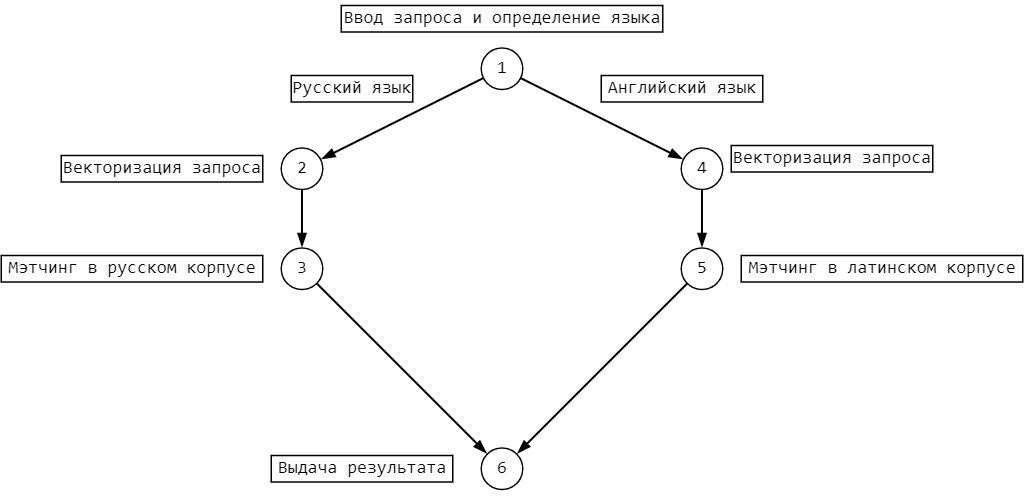

### Подготовка корпуса

Подготовим корпус с русскими и английскими названиями. Для этого оставим столбцы с айди городов и регионов, названия городов и регионов, альтернативные имена, количество населения и название страны.

In [23]:
# оставляем только нужные столбцы
corpus = cities[['geonameid_x',
                 'name_x',
                 'asciiname',
                 'alternatenames',
                 'population',
                 'country',
                 'region',
                 'geonameid_y']]

In [24]:
# функция для фильтрации пустых названий, либо названий из одного символа
def to_none(x):
    if len(x) == 0 or x == len(x) * x[0]:
        return False
    else:
        return True
'''
функция приводит к нижнему регистру и оставляет только латинские символы.
Если значение table = False, то вдобавок приводит к ascii формату
'''    
def en_text(string):
    if string == None:
        return
    string = re.sub(r'[^A-Za-z]', '', string.lower())

    return string   

'''
функция приводит к нижнему регистру и оставляет только русские символы,
запятые и символы i из белорусского и украинского языков. Это сделано для того, 
чтобы оставить названия, использующие часть русского алфавита. Если установлен
флаг table, то разделяет str по запятым и фильтрует
'''
def ru_text(string, table=True):
    if string == None:
        return
    string = re.sub(r'[^А-Яа-я,іi]', '', string.lower())
    if table:
        string = string.split(',')
        string = list(filter(to_none, string))
    return string


'''
функция для транслитерации с английского на русский
'''
translit_ru = get_translit_function('ru')
def transliterate(string):
    return [translit_ru(string.lower()).translate(string).lower()]

In [25]:
# обработка русского текста
corpus.loc[:, 'alternatenames'] = corpus.loc[:,'alternatenames']\
      .apply(ru_text)
show(corpus)

(9376, 8)


geonameid_x       name_x    asciiname            alternatenames  \
369          174969       Avshar       Avshar                        []   
370          174704   Zangakatun   Zangakatun              [зангакатун]   
371          174706      Goravan      Goravan                        []   
372          174709  Yeghegnavan  Yeghegnavan               [ехегнаван]   
373          174713       Vostan       Vostan                  [востан]   
198480      1514608    Oltinko‘l    Oltinko`l                        []   
198481      1514683  Oxunboboyev  Oxunboboyev                        []   
198482      1514707      Oqoltin      Oqoltin                        []   
198483      1514716         Oyim         Oyim               [аим, ойим]   
198484      1538533   Sultonobod   Sultonobod  [султанабад, султонобод]   

        population     country   region  geonameid_y  
369           4215     Armenia   Ararat       409313  
370           1130     Armenia   Ararat       409313  
371           2238     Armenia   Ararat       409313  
372           1221     Armenia   Ararat       409313  
373           2925     Armenia   Ararat       409313  
198480           0  Uzbekistan  Andijon      1484846  
198481           0  Uzbekistan  Andijon      1484846  
198482           0  Uzbekistan  Andijon      1484846  
198483       32750  Uzbekistan  Andijon      1484846  
198484       20000  Uzbekistan  Andijon      1484846

Часть объектов не имеет русской транслитерации, другая часть наоборот, содержит несколько вариантов. Раскроем списки и "расширим" таблицу, а также добавим русские названия там, где их не было.

In [26]:
# заменяем пустые списки на None
corpus.loc[~corpus['alternatenames'].isna(), 'alternatenames'] =\
       corpus.loc[~corpus['alternatenames'].isna(), 'alternatenames']\
             .apply(lambda x: None if len(x) == 0 else x)
show(corpus)

(9376, 8)


geonameid_x       name_x    asciiname            alternatenames  \
369          174969       Avshar       Avshar                      None   
370          174704   Zangakatun   Zangakatun              [зангакатун]   
371          174706      Goravan      Goravan                      None   
372          174709  Yeghegnavan  Yeghegnavan               [ехегнаван]   
373          174713       Vostan       Vostan                  [востан]   
198480      1514608    Oltinko‘l    Oltinko`l                      None   
198481      1514683  Oxunboboyev  Oxunboboyev                      None   
198482      1514707      Oqoltin      Oqoltin                      None   
198483      1514716         Oyim         Oyim               [аим, ойим]   
198484      1538533   Sultonobod   Sultonobod  [султанабад, султонобод]   

        population     country   region  geonameid_y  
369           4215     Armenia   Ararat       409313  
370           1130     Armenia   Ararat       409313  
371           2238     Armenia   Ararat       409313  
372           1221     Armenia   Ararat       409313  
373           2925     Armenia   Ararat       409313  
198480           0  Uzbekistan  Andijon      1484846  
198481           0  Uzbekistan  Andijon      1484846  
198482           0  Uzbekistan  Andijon      1484846  
198483       32750  Uzbekistan  Andijon      1484846  
198484       20000  Uzbekistan  Andijon      1484846

In [27]:
# создаем столбец для английского поисковика
corpus['en_name'] = corpus['asciiname'].apply(en_text)
show(corpus)

(9376, 9)


C:\Users\Kirill.V.Gusev\AppData\Local\Temp\ipykernel_22572\1003024128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['en_name'] = corpus['asciiname'].apply(en_text)


geonameid_x       name_x    asciiname            alternatenames  \
369          174969       Avshar       Avshar                      None   
370          174704   Zangakatun   Zangakatun              [зангакатун]   
371          174706      Goravan      Goravan                      None   
372          174709  Yeghegnavan  Yeghegnavan               [ехегнаван]   
373          174713       Vostan       Vostan                  [востан]   
198480      1514608    Oltinko‘l    Oltinko`l                      None   
198481      1514683  Oxunboboyev  Oxunboboyev                      None   
198482      1514707      Oqoltin      Oqoltin                      None   
198483      1514716         Oyim         Oyim               [аим, ойим]   
198484      1538533   Sultonobod   Sultonobod  [султанабад, султонобод]   

        population     country   region  geonameid_y      en_name  
369           4215     Armenia   Ararat       409313       avshar  
370           1130     Armenia   Ararat       409313   zangakatun  
371           2238     Armenia   Ararat       409313      goravan  
372           1221     Armenia   Ararat       409313  yeghegnavan  
373           2925     Armenia   Ararat       409313       vostan  
198480           0  Uzbekistan  Andijon      1484846     oltinkol  
198481           0  Uzbekistan  Andijon      1484846  oxunboboyev  
198482           0  Uzbekistan  Andijon      1484846      oqoltin  
198483       32750  Uzbekistan  Andijon      1484846         oyim  
198484       20000  Uzbekistan  Andijon      1484846   sultonobod

In [28]:
# добавляем перевод там, где не было русских названий
corpus.loc[corpus['alternatenames'].isna(), 'alternatenames'] =\
       corpus.loc[corpus['alternatenames'].isna(), 'asciiname']\
             .apply(transliterate)
show(corpus)

(9376, 9)


geonameid_x       name_x    asciiname            alternatenames  \
369          174969       Avshar       Avshar                   [авшар]   
370          174704   Zangakatun   Zangakatun              [зангакатун]   
371          174706      Goravan      Goravan                 [гораван]   
372          174709  Yeghegnavan  Yeghegnavan               [ехегнаван]   
373          174713       Vostan       Vostan                  [востан]   
198480      1514608    Oltinko‘l    Oltinko`l               [олтинко`л]   
198481      1514683  Oxunboboyev  Oxunboboyev             [оxунбобоыев]   
198482      1514707      Oqoltin      Oqoltin                 [оqолтин]   
198483      1514716         Oyim         Oyim               [аим, ойим]   
198484      1538533   Sultonobod   Sultonobod  [султанабад, султонобод]   

        population     country   region  geonameid_y      en_name  
369           4215     Armenia   Ararat       409313       avshar  
370           1130     Armenia   Ararat       409313   zangakatun  
371           2238     Armenia   Ararat       409313      goravan  
372           1221     Armenia   Ararat       409313  yeghegnavan  
373           2925     Armenia   Ararat       409313       vostan  
198480           0  Uzbekistan  Andijon      1484846     oltinkol  
198481           0  Uzbekistan  Andijon      1484846  oxunboboyev  
198482           0  Uzbekistan  Andijon      1484846      oqoltin  
198483       32750  Uzbekistan  Andijon      1484846         oyim  
198484       20000  Uzbekistan  Andijon      1484846   sultonobod

In [29]:
# раскрытие списков и расширение таблицы
temp = pd.DataFrame([*corpus['alternatenames'].values], corpus.index)\
         .stack().reset_index(-1, name='ru_name')
corpus = corpus[['geonameid_x',
                       'name_x',
                       'asciiname',
                       'alternatenames',
                       'population',
                       'country',
                       'region',
                       'en_name',
                       'geonameid_y']].join(temp)

corpus.drop(
    ['alternatenames', 'level_1'],
    inplace=True,
    axis=1)

corpus.reset_index(inplace=True, drop=True)
show(corpus)

(13039, 9)


geonameid_x       name_x    asciiname  population     country   region  \
0           174969       Avshar       Avshar        4215     Armenia   Ararat   
1           174704   Zangakatun   Zangakatun        1130     Armenia   Ararat   
2           174706      Goravan      Goravan        2238     Armenia   Ararat   
3           174709  Yeghegnavan  Yeghegnavan        1221     Armenia   Ararat   
4           174713       Vostan       Vostan        2925     Armenia   Ararat   
13034      1514707      Oqoltin      Oqoltin           0  Uzbekistan  Andijon   
13035      1514716         Oyim         Oyim       32750  Uzbekistan  Andijon   
13036      1514716         Oyim         Oyim       32750  Uzbekistan  Andijon   
13037      1538533   Sultonobod   Sultonobod       20000  Uzbekistan  Andijon   
13038      1538533   Sultonobod   Sultonobod       20000  Uzbekistan  Andijon   

           en_name  geonameid_y     ru_name  
0           avshar       409313       авшар  
1       zangakatun       409313  зангакатун  
2          goravan       409313     гораван  
3      yeghegnavan       409313   ехегнаван  
4           vostan       409313      востан  
13034      oqoltin      1484846     оqолтин  
13035         oyim      1484846         аим  
13036         oyim      1484846        ойим  
13037   sultonobod      1484846  султанабад  
13038   sultonobod      1484846  султонобод

Таким образом, каждому альтернативному названию соответствует свой geonameid. Векторизуем русский и латинский корпуса названий.

In [30]:
ru_vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(1, 2),
                             decode_error='ignore')


ru_sparse = ru_vectorizer.fit_transform(corpus['ru_name'])
ru_sparse

<13039x1072 sparse matrix of type '<class 'numpy.int64'>'
	with 181498 stored elements in Compressed Sparse Row format>

In [31]:
en_vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(1, 2),
                             decode_error='ignore')


en_sparse = en_vectorizer.fit_transform(corpus['en_name'])
en_sparse

<13039x562 sparse matrix of type '<class 'numpy.int64'>'
	with 190034 stored elements in Compressed Sparse Row format>

Для упрощения работы модуля добавим в разреженную матрицу столбцы с айди городов, регионов и количеством населения. Таким образом, при поиске названий по запросу пользователя можно будет:
- фильтровать результаты без присоединения лишних таблиц;
- быстро подцепить нужные имена регионов из базы SQL.

In [32]:
from scipy.sparse import hstack
from sqlalchemy.types import INTEGER

'''
Функция для добавления выбранных столбцов в разреженную матрицу векторов
'''
def stacking(sparse_matrix, columns, sql_name):
    # добавляем столбцы
    for i in columns:
        sparse_matrix = hstack((sparse_matrix, corpus[i].to_numpy()[:,None])).tocsr()
        
    # загружаем в PostgreSQL  
    pd.DataFrame.sparse.from_spmatrix(sparse_matrix).to_sql(
        sql_name,
        con=engine,
        dtype=INTEGER,
        if_exists='replace',
        index=False)
    
    return sparse_matrix

ru_id = stacking(ru_sparse,
                 ['geonameid_x', 'population', 'geonameid_y'],
                 'ru_sparse')

en_id = stacking(en_sparse,
                 ['geonameid_x', 'population', 'geonameid_y'],
                 'en_sparse')

pickle.dump(en_vectorizer, open("en_vector", "wb"))
pickle.dump(ru_vectorizer, open("ru_vector", "wb"))

**Промежуточный вывод:** подготовлены векторизованные представления названий населенных пунктов для выбранных стран на русском и английском языках.

## Мэтчинг

### Выбор метрики

Выведем несколько дистанций для запросов, намеренно записанных с ошибками.

In [33]:
# инициализация используемых языков
languages = [
    Language.RUSSIAN,
    Language.ENGLISH
]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

In [34]:
'''
функция определяет язык запроса, в зависимости от языка происходит
векторизация и обработка определенными инструментами, далее функция рассчитывает
расстояния и формирует таблицу с результатами. Сортировка происходит по сумме всех 
расстояний и количеству населения (больше - лучше). На вход подается список и датафрейм.
'''
def compare_dist(query, df):
    # опеделение языка, формирование столбца с расстоянием Левенштейна
    for i in query:
        if detector.detect_language_of(i).name != 'RUSSIAN':
            query_vector = en_text(i)
            temp_df = df.copy()
            temp_df['lev'] = temp_df['en_name'].apply(lambda x: ratio(x, query_vector))
            sparse = en_sparse
            vectorizer = en_vectorizer
        else:
            query_vector = ru_text(i, False)
            temp_df = df.copy()
            temp_df['lev'] = temp_df['ru_name'].apply(lambda x: ratio(x, query_vector))
            sparse = ru_sparse
            vectorizer = ru_vectorizer
         
        query_vector = vectorizer.transform([query_vector]).toarray()[0]
        
        temp_dict = {}
        dist = ['cosine', 'euclidean', 'braycurtis', 'minkowski', 'hamming', 'canberra']
        for j in dist:
            temp_dict[j] = []
        
        # добавление небольших чисел, чтобы не было нулевых данных
        for j in range(sparse.shape[0]):
            temp = sparse.getrow(j).toarray()[0]
            temp_dict['cosine'].append(1 - distance.cosine(query_vector, temp))
            temp_dict['euclidean'].append(distance.euclidean(query_vector, temp) + 0.001)
            temp_dict['braycurtis'].append(distance.braycurtis(query_vector, temp) + 0.001)
            temp_dict['hamming'].append(distance.hamming(query_vector, temp) + 0.001)
            temp_dict['canberra'].append(distance.canberra(query_vector, temp) + 0.001)
            temp_dict['minkowski'].append(distance.minkowski(query_vector, temp, p=3) + 0.001)
        
        # стандартизация
        for j in temp_dict.keys():
            temp_df[j] = temp_dict[j]
            if j not in ['cosine', 'lev']:
                temp_df[j] = min(temp_df[j])/temp_df[j]
            else:
                temp_df[j] = temp_df[j]/max(temp_df[j])
                
        temp_df['summary'] = temp_df.iloc[:, -7:].sum(axis=1)
        display(temp_df.sort_values(by=['summary', 'population']).tail(10))


In [35]:
%%time
compare_dist(['Владевосток', 'Кирафск', 'Н. Новгород', 'Stambul'], corpus)

geonameid_x       name_x    asciiname  population  country  \
1048        624923       Mastok       Mastok         650  Belarus   
7133        468835       Losevo       Losevo         640   Russia   
3423        534073       Losevo       Losevo        4476   Russia   
4304        514272    Ostashëvo    Ostashevo        2743   Russia   
2487        789485      Kladovo      Kladovo           0   Serbia   
9500       1491719     Sladkovo     Sladkovo        3455   Russia   
10066      2024858   Dostoyevka   Dostoyevka        1700   Russia   
10202      2119701       Vostok       Vostok        2779   Russia   
9981       2013279       Vostok       Vostok        3452   Russia   
9984       2013348  Vladivostok  Vladivostok      604901   Russia   

                       region      en_name  geonameid_y      ru_name  \
1048                  Mogilev       mastok       625073       мосток   
7133   Leningradskaya Oblast'       losevo       536199       лосево   
3423          Voronezh Oblast       losevo       472039       лосево   
4304            Moscow Oblast    ostashevo       524925     осташево   
2487           Central Serbia      kladovo       785958      кладово   
9500            Tyumen Oblast     sladkovo      1488747     сладково   
10066                Primorye   dostoyevka      2017623    достоевка   
10202         Sakhalin Oblast       vostok      2121529       восток   
9981                 Primorye       vostok      2017623       восток   
9984                 Primorye  vladivostok      2017623  владивосток   

            lev    cosine  euclidean  braycurtis  minkowski   hamming  \
1048   0.588235  0.693375   0.612469    0.328066   0.669555  0.502558   
7133   0.470588  0.756409   0.654746    0.328066   0.754049  0.469214   
3423   0.470588  0.756409   0.654746    0.328066   0.754049  0.469214   
4304   0.421053  0.771704   0.654746    0.368970   0.754049  0.469214   
2487   0.555556  0.762860   0.654746    0.348521   0.754049  0.469214   
9500   0.526316  0.771704   0.654746    0.368970   0.754049  0.469214   
10066  0.600000  0.834239   0.707191    0.454110   0.793791  0.541004   
10202  0.705882  0.882478   0.774668    0.458874   0.843505  0.638728   
9981   0.705882  0.882478   0.774668    0.458874   0.843505  0.638728   
9984   0.909091  1.000000   1.000000    1.000000   1.000000  1.000000   

       canberra   summary  
1048   0.461580  3.855839  
7133   0.450041  3.883115  
3423   0.450041  3.883115  
4304   0.450041  3.889778  
2487   0.450041  3.994988  
9500   0.450041  3.995041  
10066  0.529453  4.459787  
10202  0.642895  4.947031  
9981   0.642895  4.947031  
9984   1.000000  6.909091

geonameid_x    name_x asciiname  population  country  \
7265        548392   Kirovsk   Kirovsk       24678   Russia   
5415        548391   Kirovsk   Kirovsk       29605   Russia   
1079        627272   Kirawsk   Kirawsk        8700  Belarus   
8701       2022083   Kirensk   Kirensk       13308   Russia   
7264        548392   Kirovsk   Kirovsk       24678   Russia   
5414        548391   Kirovsk   Kirovsk       29605   Russia   
10052      2021644  Kraskino  Kraskino        3369   Russia   
10404       307625     Kırka     Kirka        4097   Turkey   
4738        548333      Kirs      Kirs       11385   Russia   
10633       307727     Kiraz     Kiraz       11718   Turkey   

                       region   en_name  geonameid_y   ru_name       lev  \
7265   Leningradskaya Oblast'   kirovsk       536199    кіраск  0.769231   
5415                 Murmansk   kirovsk       524304    кіраск  0.769231   
1079                  Mogilev   kirawsk       625073   кировск  0.714286   
8701           Irkutsk Oblast   kirensk      2023468   киренск  0.714286   
7264   Leningradskaya Oblast'   kirovsk       536199   кировск  0.714286   
5414                 Murmansk   kirovsk       524304   кировск  0.714286   
10052                Primorye  kraskino      2017623  краскино  0.666667   
10404               Eskisehir     kirka       315201     кирка  0.666667   
4738             Kirov Oblast      kirs       548389      кирс  0.727273   
10633          Izmir Province     kiraz       311044     кираз  0.666667   

         cosine  euclidean  braycurtis  minkowski   hamming  canberra  \
7265   0.919866   0.894461    0.857485   0.928351  0.819364  0.733360   
5415   0.919866   0.894461    0.857485   0.928351  0.819364  0.733360   
1079   0.951499   0.894461    0.928757   0.928351  0.819364  0.733360   
8701   0.951499   0.894461    0.928757   0.928351  0.819364  0.733360   
7264   0.951499   0.894461    0.928757   0.928351  0.819364  0.733360   
5414   0.951499   0.894461    0.928757   0.928351  0.819364  0.733360   
10052  0.983155   0.894461    1.000000   0.928351  0.819364  0.733360   
10404  1.000000   1.000000    0.982192   1.000000  1.000000  0.916677   
4738   0.974996   1.000000    0.893124   1.000000  1.000000  1.000000   
10633  0.982704   1.000000    0.982192   1.000000  1.000000  1.000000   

        summary  
7265   5.922118  
5415   5.922118  
1079   5.970077  
8701   5.970077  
7264   5.970077  
5414   5.970077  
10052  6.025358  
10404  6.565536  
4738   6.595393  
10633  6.631562

geonameid_x            name_x         asciiname  population  country  \
5867       519336  Velikiy Novgorod  Velikiy Novgorod      222868   Russia   
5618      1497095        Novogornyy        Novogornyy        8132   Russia   
7283       555624         Ivangorod         Ivangorod       11074   Russia   
7284       555624         Ivangorod         Ivangorod       11074   Russia   
1187       628155           Gorodok           Gorodok       12410  Belarus   
654        627904            Hrodna            Hrodna      373547  Belarus   
6296       520555  Nizhniy Novgorod  Nizhniy Novgorod     1259013   Russia   
3188       559542          Gorodnya          Gorodnya        5000   Russia   
7043       517144      Novyye Gorki      Novyye Gorki        2877   Russia   
5869       519336  Velikiy Novgorod  Velikiy Novgorod      222868   Russia   

                      region          en_name  geonameid_y         ru_name  \
5867         Novgorod Oblast  velikiynovgorod       519324  великиновгород   
5618             Chelyabinsk       novogornyy      1508290      новогорный   
7283  Leningradskaya Oblast'        ivangorod       536199       івангород   
7284  Leningradskaya Oblast'        ivangorod       536199       ивангород   
1187                 Vitebsk          gorodok       620134         городок   
654             Grodnenskaya           hrodna       628035          гродно   
6296  Nizhny Novgorod Oblast  nizhniynovgorod       559838  нижнийновгород   
3188             Tver Oblast         gorodnya       480041         городня   
7043          Ivanovo Oblast      novyyegorki       555235        новгорки   
5869         Novgorod Oblast  velikiynovgorod       519324        новгород   

           lev    cosine  euclidean  braycurtis  minkowski   hamming  \
5867  0.695652  0.787615   0.353715    0.198946   0.464356  0.218306   
5618  0.631579  0.801743   0.408419    0.189930   0.550518  0.235006   
7283  0.666667  0.764593   0.408419    0.179408   0.550518  0.235006   
7284  0.666667  0.764593   0.408419    0.179408   0.550518  0.235006   
1187  0.625000  0.764593   0.408419    0.189930   0.500198  0.305004   
654   0.533333  0.808804   0.447388    0.177304   0.584996  0.277457   
6296  0.782609  0.825897   0.353715    0.231983   0.436985  0.277457   
3188  0.625000  0.806738   0.447388    0.189930   0.584996  0.277457   
7043  0.705882  0.808318   0.447388    0.202552   0.584996  0.277457   
5869  0.941176  1.000000   1.000000    1.000000   1.000000  1.000000   

      canberra   summary  
5867  0.114362  2.832952  
5618  0.111185  2.928380  
7283  0.126665  2.931276  
7284  0.126665  2.931276  
1187  0.148243  2.941387  
654   0.156349  2.985631  
6296  0.145020  3.053666  
3188  0.156349  3.087858  
7043  0.156349  3.182943  
5869  1.000000  6.941176

geonameid_x    name_x asciiname  population     country         region  \
5291        484646    Tambov    Tambov      293661      Russia  Tambov Oblast   
5292        484646    Tambov    Tambov      293661      Russia  Tambov Oblast   
5293        484646    Tambov    Tambov      293661      Russia  Tambov Oblast   
1684       1524451  Dzhambul  Dzhambul        1336  Kazakhstan      Karaganda   
1685       1524451  Dzhambul  Dzhambul        1336  Kazakhstan      Karaganda   
9578       1498257    Mul’ta    Mul'ta         704      Russia          Altai   
9579       1498257    Mul’ta    Mul'ta         704      Russia          Altai   
12177       745044  Istanbul  Istanbul    14804116      Turkey       Istanbul   
12178       745044  Istanbul  Istanbul    14804116      Turkey       Istanbul   
12179       745044  Istanbul  Istanbul    14804116      Turkey       Istanbul   

        en_name  geonameid_y     ru_name       lev    cosine  euclidean  \
5291     tambov       484638      тамбов  0.615385  0.817424   0.894461   
5292     tambov       484638       тамбо  0.615385  0.817424   0.894461   
5293     tambov       484638       томбу  0.615385  0.817424   0.894461   
1684   dzhambul      1523401     джамбул  0.666667  0.900000   0.894461   
1685   dzhambul      1523401      жамбыл  0.666667  0.900000   0.894461   
9578      multa      1506272    замульта  0.500000  0.903696   1.000000   
9579      multa      1506272      мульта  0.500000  0.903696   1.000000   
12177  istanbul       745042  византиаii  0.800000  1.000000   1.000000   
12178  istanbul       745042    истанбул  0.800000  1.000000   1.000000   
12179  istanbul       745042     стамбул  0.800000  1.000000   1.000000   

       braycurtis  minkowski   hamming  canberra   summary  
5291     0.686467   0.928351  0.810642   0.80002  5.552749  
5292     0.686467   0.928351  0.810642   0.80002  5.552749  
5293     0.686467   0.928351  0.810642   0.80002  5.552749  
1684     0.800558   0.928351  0.810642   0.80002  5.800699  
1685     0.800558   0.928351  0.810642   0.80002  5.800699  
9578     0.786302   1.000000  1.000000   1.00000  6.189998  
9579     0.786302   1.000000  1.000000   1.00000  6.189998  
12177    1.000000   1.000000  1.000000   1.00000  6.800000  
12178    1.000000   1.000000  1.000000   1.00000  6.800000  
12179    1.000000   1.000000  1.000000   1.00000  6.800000

CPU times: total: 17.9 s
Wall time: 18 s


Заметно, что в названиях, где большинство метрик ошибается, косинусное расстояние и расстояние Минковского показывают себя лучше (Кировск, Новгород).

### Проверка на тестовом датасете

Для проверки на тесте немного перепишем предыдущую функцию, чтобы она возвращала список названий. Также используем только косинусное расстояние и расстояние Минковского.

In [36]:
'''
функция определяет язык запроса, в зависимости от языка происходит
векторизация и обработка определенными инструментами, далее функция рассчитывает
расстояния и формирует список с названиями. Сортировка происходит по сумме всех 
расстояний и количеству населения (больше - лучше)
'''
def matching(query, df):
    answer = []
    for i in query:
        if detector.detect_language_of(i).name != 'RUSSIAN':
            query_vector = en_text(i)
            temp_df = df.copy()
            sparse = en_sparse
            vectorizer = en_vectorizer
        else:
            query_vector = ru_text(i, False)
            temp_df = df.copy()
            sparse = ru_sparse
            vectorizer = ru_vectorizer
         
        query_vector = vectorizer.transform([query_vector]).toarray()[0]
        
        temp_dict = {}
        dist = ['cosine', 'minkowski']
        for j in dist:
            temp_dict[j] = []
        
        for j in range(sparse.shape[0]):
            temp = sparse.getrow(j).toarray()[0]
            temp_dict['cosine'].append(1 - distance.cosine(query_vector, temp))
            temp_dict['minkowski'].append(distance.minkowski(query_vector, temp, p=3) + 0.001)
        
        for j in temp_dict.keys():
            temp_df[j] = temp_dict[j]
            if j not in ['cosine']:
                temp_df[j] = min(temp_df[j])/temp_df[j]
            else:
                temp_df[j] = temp_df[j]/max(temp_df[j])
                
        temp_df['summary'] = temp_df.iloc[:, -2:].sum(axis=1)
        answer.append(temp_df.sort_values(by=['summary', 'population']).iloc[-1, 1])
    return answer

In [37]:
ru_test = matching(list(test['query']), corpus)

Создадим таблицу с ответами и выведем долю верно определенных названий.

In [38]:
check = pd.DataFrame({'predict':ru_test, 'true':test['name']})
check['result'] = check['predict'] == check['true']
check['result'].sum()/len(check)

0.9478260869565217

In [39]:
check.query('result == False')

predict              true  result
10              Minsk        Minsk City   False
15               Oral     Yekaterinburg   False
17   Velikiy Novgorod  Nizhniy Novgorod   False
31           Kostanay            Astana   False
54          Lesogorsk         Salihorsk   False
63           Zaslawye         Yaroslavl   False
85   Saint Petersburg       Kaliningrad   False
87           Tolyatti        Stavropol’   False
91       Staryy Biser            Serbia   False
96              Areni           Armenia   False
99             Atyrau            Atyraū   False
105         Samarkand          Temirtau   False
119            Dankov          Zhanibek   False
128          Pavlodar   Pavlodar Region   False
166      Novaya Lyada    Novaya Adygeya   False
241        Oktyabrsky      Oktyabr’skiy   False
313    Horad Zhodzina        Drozhzhino   False
318            Kokrek         Krekshino   False

Заметно, что некоторые названия в столбце `true` совпадают с предсказанными, но записаны чуть по-другому, например, Минск, Атырау, Октябрьский. Таким образом, для наивного подхода получен результат выше 95%, что довольно неплохо.

**Промежуточный вывод:** в рамках данной главы было проведено достаточно много исследований, которые не попали в итоговую тетрадку. Их описание представлено ниже.
1. Векторизация названий, используя различные N-грамы. Было исследовано несколько вариантов, от 1 до 4. В результате было принято решение оставить последовательность из двух элементов, так как при нём получалось наилучшее сочетание производительности/метрики.
2. Использование трансформеров. Данный подход показал метрику хуже, чем у наивного способа (векторизация), при этом дообучение заняло очень долгое время.
3. Использование других переводчиков. Был также протестирован гугл-переводчик, но он периодически "ломался", также испытавался deep translator, но он очень медленно работает, поэтому был выбран пакет "transliterate", несмотря на периодические факапы (Zayed City переводит как Зыед Циты), он выдает адекватный результат за рекордное время.
3. Подготовка корпуса названий по всему датасету, не только по странам СНГ. Данный подход хорош тем, что всегда есть векторизованная матрица, которая содержит в себе все названия. Главный минус - очень медленная скорость выдачи названий, то есть запрос обрабатывается порядка полутора минут на локальной машине. Проверка тестового датасета заняла около пяти часов. Также наблюдается несильное падение метрики, так как появляются новые похожие названия, например: "Bisbi"~"Spb". Интересное наблюдение - для общего датасета метрика Брея-Кертиса работала лучше, чем метрика Минковского, поэтому не исключается вариант, когда используются все три дистанции (косинусное, Минковского, Брея-Кертиса) с различными коэффициентами.

По результатам исследований был выбран подход, основанный на векторизации предобработанного корпуса на русском и английским языках. В качестве дистанций исполоьзуется косинусное расстояние и расстояние Минковского. На данном подходе был создан модуль `geonames` для выдачи унифицированных названий.

## Тестирование модуля

Модуль состоит из нескольких частей:
- импорты;
- общие функции;
- класс SqlConnector;
- класс CreateSparse;
- класс Matching.

Работу с модулем можно условно разделить на несколько этапов:
1. Импорт модуля
2. Настраиваемое соединение с базой данных
3. (Опционально) Выбор стран, в которых планируется поиск, далее векторизация соответствующих корпусов.
4. Поиск

### Импорт и соединение с базой данных

Модуль позволяет настроить соединение с базой SQL, из которой будут подгружаться таблицы.

In [40]:
import geonames

DATABASE = {
    'drivername': 'postgresql',
    'username': 'postgres', 
    'password': '112358', 
    'host': 'localhost',
    'port': 5432,
    'database': 'postgres',
    'query': {}
}

# присоединились к базе данных SQL
connect = geonames.SqlConnector(DATABASE)

Для дальнейшей работы необходимо скачать векторизованные матрицы и сами векторайзеры. Матрицы могут уже находиться в базе SQL, а модели лежать в корне.

In [41]:
# скачиваем разреженные матрицы из базы SQL по их названиям
ru_sparse = connect.download_sparse('ru_sparse')
en_sparse = connect.download_sparse('en_sparse')

# подгружаем предобученные векторайзеры
ru_vec = connect.download_vec('ru_vector')
en_vec = connect.download_vec('en_vector')

### Поиск названий

В данный момент, векторизованные представления названий соответствуют странам СНГ, Грузии и Турции, как и предобученные модели. Допустим, мы хотим оставить это как есть и производить поиск в пределах данных стран. Для этого используем класс `Matching`. При его инициализации необходимо указывать engine для связи с базой SQL, а также разреженные матрицы с векторайзерами.

In [42]:
module = geonames.Matching(ru_sparse=ru_sparse,
                           en_sparse=en_sparse,
                           ru_vectorizer=ru_vec,
                           en_vectorizer=en_vec,
                           engine = connect.engine)

Модуль готов!


Чтобы запустить поиск, используем метод `find` с запросом, по умолчанию метод выводит три ближайших названия в виде словаря с полями `geonameid`, `Country`, `region`, `cosine`. Очередность вывода согласно косинусным расстояниям.

In [43]:
module.find('Владивастоук')

[{'geonameid': 2013348,
  'name': 'Vladivostok',
  'Country': 'Russia',
  'region': 'Primorye',
  'cosine': 1.0},
 {'geonameid': 472357,
  'name': 'Volosovo',
  'Country': 'Russia',
  'region': "Leningradskaya Oblast'",
  'cosine': 0.7943406249793323},
 {'geonameid': 540103,
  'name': 'Kstovo',
  'Country': 'Russia',
  'region': 'Nizhny Novgorod Oblast',
  'cosine': 0.789672569132238}]

In [44]:
module.find('Киравкс', 5)

[{'geonameid': 499727,
  'name': 'Rzhavki',
  'Country': 'Russia',
  'region': 'Moscow Oblast',
  'cosine': 1.0},
 {'geonameid': 307625,
  'name': 'Kırka',
  'Country': 'Turkey',
  'region': 'Eskişehir',
  'cosine': 1.0},
 {'geonameid': 307727,
  'name': 'Kiraz',
  'Country': 'Turkey',
  'region': 'İzmir Province',
  'cosine': 0.982703641586785},
 {'geonameid': 548333,
  'name': 'Kirs',
  'Country': 'Russia',
  'region': 'Kirov Oblast',
  'cosine': 0.974996043043569},
 {'geonameid': 548391,
  'name': 'Kirovsk',
  'Country': 'Russia',
  'region': 'Murmansk',
  'cosine': 0.9514987095307502}]

In [45]:
module.find('Myrmansk', 2)

[{'geonameid': 524305,
  'name': 'Murmansk',
  'Country': 'Russia',
  'region': 'Murmansk',
  'cosine': 1.0},
 {'geonameid': 566629,
  'name': 'Demyansk',
  'Country': 'Russia',
  'region': 'Novgorod Oblast',
  'cosine': 0.8364567316637355}]

### Поиск в других странах

Предположим, что нужно расширить или наоборот уменьшить зону поиска. Для это можно воспользоваться классом `CreateSparse`. При его инициализации необходимо указывать engine для связи с базой SQL, а также таблицу городов, названия которой мы будем использовать. В данном случае это cities500. По умолчанию уже установлены вспомогательные таблицы для названий регионов и стран, однако при необходимости это можно изменить.

In [46]:
loader = geonames.CreateSparse(engine=connect.engine,
                               main_table='cities500')

Модуль готов!


Методы класса позволяют добавлять, убирать, очищать и проверять список стран для поиска. Обозначения стран согласно ISO.

In [47]:
# добавим Испанию
loader.add(['es'])

Добавлены следующие страны: ['es']
Поиск по странам: ['AZ', 'AM', 'BY', 'KG', 'KZ', 'MD', 'RU', 'TJ', 'UZ', 'GE', 'RS', 'TR', 'ES']


In [48]:
# удалим Казахстан
loader.remove(['kz'])

Убраны следующие страны: ['KZ']
Поиск по странам: ['AZ', 'AM', 'BY', 'KG', 'MD', 'RU', 'TJ', 'UZ', 'GE', 'RS', 'TR', 'ES']


In [49]:
# полностью очистим список стран
loader.clear()

Список стран очищен


In [50]:
# проверим
loader.check()

Поиск по странам: []


In [51]:
# добавим Италию
loader.add(['it'])

Добавлены следующие страны: ['it']
Поиск по странам: ['IT']


Чтобы провести поиск по измененному составу стран, необходимо создать новую разреженную матрицу и модели. Для этого используем метод `Vectorize`.

In [52]:
# метод выдает готовые разреженные матрицы
ru_sparse, en_sparse = loader.vectorize()

Векторизация завершена.


In [53]:
# подгружаем обновленные модели
ru_vec = connect.download_vec('ru_vector')
en_vec = connect.download_vec('en_vector')

In [54]:
module = geonames.Matching(ru_sparse=ru_sparse,
                           en_sparse=en_sparse,
                           ru_vectorizer=ru_vec,
                           en_vectorizer=en_vec,
                           engine = connect.engine)

Модуль готов!


In [55]:
module.find('Рим')

[{'geonameid': 3169070,
  'name': 'Rome',
  'Country': 'Italy',
  'region': 'Lazio',
  'cosine': 1.0},
 {'geonameid': 3169366,
  'name': 'Rima',
  'Country': 'Italy',
  'region': 'Piedmont',
  'cosine': 0.8451542547285167},
 {'geonameid': 3169361,
  'name': 'Rimini',
  'Country': 'Italy',
  'region': 'Emilia-Romagna',
  'cosine': 0.7592566023652966}]

In [56]:
module.find('Владивосток')

[{'geonameid': 2523975,
  'name': 'Olivadi',
  'Country': 'Italy',
  'region': 'Calabria',
  'cosine': 0.9906226997870246},
 {'geonameid': 3174661,
  'name': 'Livo',
  'Country': 'Italy',
  'region': 'Trentino-Alto Adige',
  'cosine': 0.96674876498663},
 {'geonameid': 3174662,
  'name': 'Livo',
  'Country': 'Italy',
  'region': 'Lombardy',
  'cosine': 0.96674876498663}]

Владивосток ожидаемо не находит, так как в пуле стран осталась только Италия.

**Промежуточный вывод:** модуль уверенно находит города, написанные на русском и английском языках, причем даже ошибочные названий интерпретируются корректно. Для ускорения процесса поиска можно создать несколько векторизованных матриц и моделей, условно для разных частей света, и подгружать нужные в процессе работы.

## Вывод

**Ход исследовательской работы**

В рамках данной задачи были выполнены следующие этапы:

- проведены исследование и предобработка данных;
- заполнены пропуски;
- выполнена проверка на дубликаты;
- созданы два векторизованных корпуса;
- проведено исследование влияния векторных расстояний на результат.

В качестве MVP был выбран подход с суммарным косинусным расстоянием и расстоянием Минковского.

**Результаты исследовательской работы**

На тестовом датасете получена точность выше 95%. На основе данных, полученных в ходе исследовательских работ, был создан модуль `geonames`, который по запросу пользователя подбирает подходящие названия geonames с высокой точностью. Также модуль позволяет:
- настраивать поключение к БД;
- векторизировать корпуса названий и варьировать списком стран для поиска;
- хранить векторизованные данные в PostgreSQL;
- настраивать количество названий для выдачи.

При этом модуль "терпим" к возможным ошибкам ввода, благодаря комбинации расстояний.

**Рекомендации по улучшению решения**

1. Параметризовать веса расстояний и попробовать решить задачу оптимизации весов с помощью нейросети.
2. В настоящий момент все объекты с пропусками в ключевых столбцах удаляются, поэтому необходимо предусмотреть процесс заполнения пропусков.
3. Предусмотреть ввод на языке, написанном не на латинице/кириллице.